In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Global variables
BATCH_SIZE = 128
EPOCHS = 100

In [3]:
# Get the class weights from a JSON file
with open('./json/class_weights.json', "r") as f:
    class_weight_dict = json.load(f)

In [4]:
# Preprocessed data
X_train = np.load('preprocessed_data/X_train.npy')
y_train = np.load('preprocessed_data/y_train.npy')
X_test = np.load('preprocessed_data/X_test.npy')
y_test = np.load('preprocessed_data/y_test.npy')

In [5]:
# Transform the y_train and y_test labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_cat = to_categorical(y_test, num_classes=len(np.unique(y_train)))

In [6]:
# Model definition
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(60, X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(64)) 
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [9]:
# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.5388 - loss: 1.1907 - val_accuracy: 0.6315 - val_loss: 0.8974
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.6777 - loss: 0.8033 - val_accuracy: 0.6541 - val_loss: 0.9379
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.6922 - loss: 0.7675 - val_accuracy: 0.7425 - val_loss: 0.6301
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.7400 - loss: 0.6348 - val_accuracy: 0.7611 - val_loss: 0.5578
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.7491 - loss: 0.5936 - val_accuracy: 0.7577 - val_loss: 0.5372
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.7778 - loss: 0.5345 - val_accuracy: 0.7855 - val_loss: 0.4862
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.7863 - loss: 0.5180 - val_accuracy: 0.7799 - val_loss: 0.4921
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.8081 - loss: 0

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


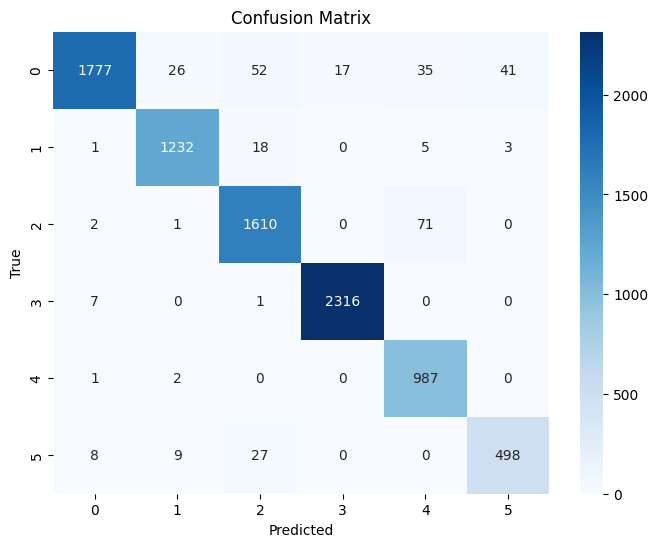

In [10]:
# Predictions
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
# Classification report
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.989     0.912     0.949      1948
           1      0.970     0.979     0.974      1259
           2      0.943     0.956     0.949      1684
           3      0.993     0.997     0.995      2324
           4      0.899     0.997     0.945       990
           5      0.919     0.919     0.919       542

    accuracy                          0.963      8747
   macro avg      0.952     0.960     0.955      8747
weighted avg      0.964     0.963     0.963      8747



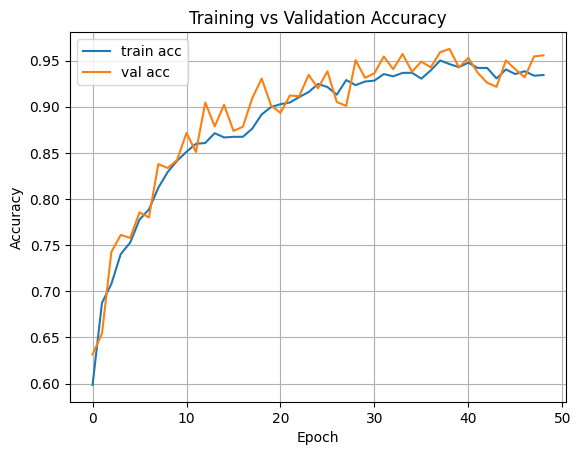

In [12]:
# Plot the training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Save the model
model.save('trained_models/lstm_batchnorm_model.h5')
model.save('trained_models/lstm_batchnorm_model.keras')